In [23]:
from IPython.core.display import HTML
HTML("""
<style>
p {
    font-size: 20px;
}
h1 {
    font-family: verdana;
    font-size: 25px;
    background-color: #003262;
    color: #fdb515;
}
ul {
    font-size: 20px;
}
table {
    float: left;
    font-size: 20px;
    text-align: left;
    border-collapse: collapse;
}
</style>
""")

# Cuneiform Computational Text Analysis

![Berkeley Seal](files/ucbseal_139_540.png)
## In Honor of Miguel Civil
Niek Veldhuis, UC Berkeley


In [19]:
#! pip install tqdm
#! pip install pyLDAvis
from datascience import *
from tqdm import *
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import webbrowser
import pyLDAvis
import json

# 1. Introduction

## Topic Modeling: Neo Assyrian Letters (from SAA)
This topic model was prepared by Gil Breger.

Each topic consists of a list of words that are prominent in that topic. In the visualization the left pane illustrates the distance between topics. The slider on the right allows the user to use different types of weighting for each of the words in the topic.

In [24]:
phi = 'SAA-topic-model/SAAphi.csv'
theta = 'SAA-topic-model/SAAtheta.csv'
doclength = 'SAA-topic-model/SAAdoclength.csv'
vocabulary = 'SAA-topic-model/SAAvocab.csv'
termfreq = 'SAA-topic-model/SAAtermfreq.csv'
topic_term_dists = np.genfromtxt(phi, delimiter=',', skip_header=1)
doc_topic_dists = np.genfromtxt(theta, delimiter=',', skip_header=1)
doc_lengths = np.genfromtxt(doclength, delimiter=',', skip_header=1)
term_frequency = np.genfromtxt(termfreq, delimiter=',', skip_header=1)
with open(vocabulary, 'r', encoding='utf8') as f:
    vocab = f.read().splitlines()
vocab = vocab[1:]
data = {'topic_term_dists': topic_term_dists, 
            'doc_topic_dists': doc_topic_dists,
            'doc_lengths': doc_lengths,
            'vocab': vocab,
            'term_frequency': term_frequency,
            'R': 20
       }
SAA_vis_data = pyLDAvis.prepare(**data)
pyLDAvis.display(SAA_vis_data)

# 2. Three Phases of Computational Text Analysis

- Data Acquisition and Data Cleaning
- Data Analysis
- Evaluation


## 2.1 Data Acquisition and Data Cleaning

The scrapers [ORACC Scraper](../Scrape-Oracc/Scrape Oracc.ipynb) and [scrape-etcsl-XML](../Scrape-etcsl/scrape-etcsl-XML.ipynb) create data in compatible format.

> ETCSL:    du₃ (V) to build<br>

> ORACC:    du[build]V/t/du₃


Output of the beginning of Gilgameš and Aga:

> etcsl_no,text_name,version,l_no,text

> c.1.8.1.1,Gilgameš and Aga,,1,sux:kiŋgia[messenger]N sux:Aga[1]RN sux:dumu[child]N sux:Enmebaragesi[1]RN

> c.1.8.1.1,Gilgameš and Aga,,2,sux:Kiš[1]SN sux:Gilgameš[1]DN sux:Unug[1]SN sux:ŋen[go]V/i

> c.1.8.1.1,Gilgameš and Aga,,3,sux:Gilgameš[1]DN sux:igi[eye]N sux:abba[father]N sux:iri[city]N

> c.1.8.1.1,Gilgameš and Aga,,4,sux:inim[word]N sux:ŋar[place]V/t sux:inim[word]N sux:kiŋ[seek]V/t

Example of alternative output format (for tree banking):
<table>
<tr><td>lugal-e</td><td>lugal[king]</td><td>N</td></tr>
<tr><td>e₂</td><td>e[hose]</td><td>N</td></tr>
<tr><td>mu-un-du₃</td><td>du[build]</td><td>V/t</td></tr>
</table>


# 2.2 Analysis: Lexical and Literary Texts

In [23]:
decad_selection = ['c.2.4.2.01', 'c.2.5.5.1', 'c.5.5.4','c.4.07.2', 'c.4.05.1', 'c.4.80.2', 
                 'c.1.1.4','c.1.3.2', 'c.4.28.1', 'c.1.8.1.5']
decad_titles = ['Shulgi A', 'Lipit-Estar A', 'Song of the hoe', 'Inana B','Enlil A','Kesh Temple Hymn',
                "Enki's Journey to Nippur",'Inana and Ebih',"Nungal A",'Gilgamesh and Huwawa']


# Load the Lexical Compositions

The 13 lexical texts listed have been scraped from ORACC with [Scrape Oracc](../Scrape-Oracc/Scrape Oracc.ipynb). 

The script below connects multiple-word expressions with a `*`, as in

> `sux:gud[oxen]N*sux:babbar[white]AJ`


In [24]:
lexical_texts = ["Q000039", "Q000040", "Q000001", "Q000041", "Q000042", "Q000043"
                 , "Q000047", "Q000050", "Q000048", "Q000052", "Q002268", "Q000302", "Q000057"]
lexical_titles = ["Ura 1", "Ura 2", "Ura 3", "Ura 4", "Ura 5", "Ura 6", "Lu", "Izi", "Kagal",
                  "Nigga", "Ugumu", "Lu-Azlag", "Diri"]
lex_table = Table(['id_text', 'l_no', 'text'])
lexical_text_lengths = []
for lex in tqdm(lexical_texts):
    Q = Table.read_table('Lex-Data/dcclt_' + lex + '.txt', sep=',', usecols = ['id_text', 'l_no', 'text'])
    length = Q.num_rows
    lexical_text_lengths.append(length)
    lex_table.append(Q)
lex_table = lex_table.where('text', are.not_equal_to('nan')) #kick out empty cells
lex_lines = lex_table['text']
lex_lines = [line.lower() for line in lex_lines]
lex_lines = [item.replace(' ', '*') for item in lex_lines]
lex_table.append_column('text', lex_lines)
lex_table_multiple_word = [item for item in lex_table['text'] if '*' in item]
lex_table_multiple_word.sort(key=len, reverse=True)
lex_table

100%|█████████████████████████████████████████| 13/13 [00:00<00:00, 206.33it/s]


id_text,l_no,text
dcclt/Q000039,1,sux:taškarin[boxwood]n
dcclt/Q000039,2,sux:esi[tree]n
dcclt/Q000039,3,sux:ŋešnu[tree]n
dcclt/Q000039,4,sux:halub[tree]n
dcclt/Q000039,5,sux:šagkal[tree]n
dcclt/Q000039,6,sux:ŋešgana[tree]n
dcclt/Q000039,6a,sux:ŋešgana[tree]n*sux:babbar[white]v/i
dcclt/Q000039,6b,sux:ŋešgana[tree]n*sux:giggi[black]v/i
dcclt/Q000039,7,sux:ŋeš[tree]n*sux:giggi[black]v/i
dcclt/Q000039,8,sux:ŋeštin[vine]n


# Load the Literary Corpus

In [25]:
with open('../Scrape-etcsl/Input/etcsl.txt', mode='r') as f:
    etcsl = f.read().splitlines()
etcsl_table = Table(['etcsl_no', 'text_name', 'version', 'l_no', 'text'])
for comp in tqdm(etcsl):
    one_comp = Table.read_table('../Scrape-etcsl/cleaned/' + comp + '.txt', sep=',')
    etcsl_table = etcsl_table.append(one_comp)
etcsl_table = etcsl_table.where('text', are.not_equal_to('nan'))
etcsl_text = etcsl_table['text']
etcsl_text = [line.lower() for line in etcsl_text]
etcsl_table.append_column('text', etcsl_text)
etcsl_no_name = etcsl_table.select(['etcsl_no', 'text_name'])
etcsl_no_name_df = etcsl_no_name.to_df()
etcsl_no_name_df.drop_duplicates('etcsl_no', inplace=True)
etcsl_no_name_df.set_index('etcsl_no', inplace=True)
etcsl_table

100%|████████████████████████████████████████| 394/394 [00:08<00:00, 35.15it/s]


etcsl_no,text_name,version,l_no,text
c.0.1.1,Ur III catalogue from Nibru (N1),nan,1,sux:dubsaŋ[first]aj
c.0.1.1,Ur III catalogue from Nibru (N1),nan,2,sux:enki[1]dn sux:unu[dwelling]n sux:gal[big]v/i sux:ed[ ...
c.0.1.1,Ur III catalogue from Nibru (N1),nan,3,sux:anzag[horizon]n
c.0.1.1,Ur III catalogue from Nibru (N1),nan,4,sux:anŋi[eclipse]n sux:zu[know]v/t sux:ama[mother]n sux: ...
c.0.1.1,Ur III catalogue from Nibru (N1),nan,5,sux:gi[thicket]n sux:tuku[rock]v/t
c.0.1.1,Ur III catalogue from Nibru (N1),nan,6,sux:me[battle]n
c.0.1.1,Ur III catalogue from Nibru (N1),nan,7,sux:mašmaš[sorcerer]n sux:erim[enemy]n sux:kur[different]v/i
c.0.1.1,Ur III catalogue from Nibru (N1),nan,8,sux:ŋiriŋena[path]n sux:enki[1]dn sux:ki[place]n sux:unu ...
c.0.1.1,Ur III catalogue from Nibru (N1),nan,9,sux:šag[heart]n sux:1-kam-ma[1st]nu
c.0.1.1,Ur III catalogue from Nibru (N1),nan,10,sux:dubsaŋ[first]aj


# Make a Document Term Matrix (DTM)

- Row: a composition in ETCSL
- Column: a unique word in the corpus
- Cell: how often does this word appear in this composition?


In [26]:
cv = CountVectorizer(analyzer='word', token_pattern=r'[^ ]+')
etcsl_bag_of_words = etcsl_table.select(['etcsl_no', 'text']).group('etcsl_no', collect=' '.join)
etcsl_no = etcsl_bag_of_words['etcsl_no']
etcsl_dtm = cv.fit_transform(etcsl_bag_of_words['text join'])
etcsl_df = pd.DataFrame(etcsl_dtm.toarray(), columns = cv.get_feature_names(), index = etcsl_bag_of_words['etcsl_no'])
etcsl_text_length =  etcsl_df.sum(axis=1)
etcsl_df.head(10)

,sux-x-emesal:am-mu-uc[3]nu,sux-x-emesal:aŋ[do]v/t,sux-x-emesal:aŋ[sky]n,sux-x-emesal:aŋ[thing]n,sux-x-emesal:aŋba[gift]n,sux-x-emesal:aŋdara[rag]n,sux-x-emesal:aŋgig[bad-thing]n,sux-x-emesal:aŋhulu[evil]n,sux-x-emesal:aŋlam[garment]n,sux-x-emesal:aŋsub[polishing]n,...,sux:šusuen[1]rn,sux:šutubur[mixture]n,sux:šutug[reed-hut]n,sux:šutum[storehouse]n,sux:šutur[garment]n,sux:šuziana[1]dn,sux:šuš[cover]v/t,sux:šuʾi[barber]n,sux:šuʾu[stone]n,sux:šuʾura[goose]n
c.0.1.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
c.0.1.2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
c.0.2.01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
c.0.2.02,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
c.0.2.03,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
c.0.2.04,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
c.0.2.05,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
c.0.2.06,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
c.0.2.07,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
c.0.2.08,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# How many Words appear only Once?
This includes numbers and proper nouns

In [27]:
etcsl_rare_df = etcsl_df.ix[0:,etcsl_df.sum(axis=0) == 1]
len(etcsl_rare_df.columns)

1308

# How many King Names?

And how may of those appear only once?

In [28]:
etcsl_words = list(etcsl_df.columns)
etcsl_rn = [rn for rn in etcsl_words if rn[-2:] == 'rn']
etcsl_rn_df = etcsl_df[etcsl_rn]
etcsl_rare_rn_df = etcsl_rn_df.ix[0:, etcsl_rn_df.sum() ==1]
len(etcsl_rn), len(etcsl_rare_rn_df.columns)

(178, 98)

# How many of these rare kings in SKL?

In [29]:
skl_l = list(etcsl_rare_rn_df.loc['c.2.1.1'])
skl_rare_rn = [rn for rn in skl_l if rn == 1]
len(skl_rare_rn)

86

# In which Texts do we find rare Kings?

In [30]:
rare_king_df = etcsl_rare_rn_df[etcsl_rare_rn_df.sum(axis=1) > 0]
rare_king_texts = list(rare_king_df.index)
etcsl_no_name_df.loc[rare_king_texts]

,text_name
etcsl_no,
c.0.2.03,OB catalogue from Urim (U1)
c.0.2.11,OB catalogue at Andrews University (B4)
c.1.7.1,The marriage of Martu
c.2.1.1,The Sumerian king list
c.2.1.2,The rulers of Lagaš
c.2.1.3,The history of the Tummal
c.2.7.1.1,A praise poem of Anam (Anam A)
c.6.1.01,Proverbs: collection 1
c.6.1.14,Proverbs: collection 14


# Find Lexical Multiple-Word Expressions in the Literary Corpus
This computation goes back to the original table (`etcsl_table`) above in order to identify lines that contain multiple-word expressions that are attested in the lexical corpus. Every line in the literary corpus is compared to every multiple-word line in the lexical corpus. When a match is found, a `*` is inserted to connect the words in the expression in the literary composition.

The script compares 34,954 literary lines with 4633 lexical expressions; a total of 161,941,882 or almost 162 million comparisons. This cell takes about 2-3 minutes to run.

In [31]:
etcsl_text = etcsl_table['text']
newlines = []
for line in tqdm(etcsl_text):
    for item in lex_table_multiple_word:
        find = item.replace('*', ' ')
        line = line.replace(find, item)
    newlines.append(line)
etcsl_table.append_column('text', newlines)

100%|███████████████████████████████████| 34954/34954 [01:44<00:00, 333.71it/s]


# Create Lex-Lit DTM
The Document-Term matrix created below allows *only* the words and expressions that are attested in the 13 lexical texts under consideration. Note that the CountVectorizer is set to ```binary = True```: the cells indicate whether or not a word or expression is attested in the compositions (1 or 0); attestations are not counted.

In [32]:
table = etcsl_table.select(['etcsl_no', 'text']).group('etcsl_no', collect=' '.join)
table = table.relabel('text join', 'text')
lex_vocab = list(set(lex_table['text']))
lex_vocab.sort()
cv = CountVectorizer(analyzer='word', token_pattern=r'[^ ]+', binary = True, 
                     vocabulary=lex_vocab)
etcsl_dtm = cv.fit_transform(table['text'])
etcsl_df = pd.DataFrame(etcsl_dtm.toarray(), columns = lex_vocab, index = etcsl_no)
etcsl_df.head(10)

,sux-x-emesal:ašer[lament]n,sux-x-emesal:mušnud[bed]n,sux-x-emesal:subad[shepherd]n,sux:a[arm]n,sux:a[arm]n*sux:ak[do]v/t,sux:a[arm]n*sux:apin[plow]n,sux:a[arm]n*sux:bad[open]v/t,sux:a[arm]n*sux:be[diminish]v/t,sux:a[arm]n*sux:da[line]n,sux:a[arm]n*sux:dar[split]v/t,...,sux:šuʾa[stool]n*sux:niŋgula[greatness]n,sux:šuʾa[stool]n*sux:tibira[sculptor]n,sux:šuʾabdu[1]wn,sux:šuʾi[barber]n,sux:šuʾi[barber]n*sux:egir[back]n,sux:šuʾi[barber]n*sux:gina[offering]n,sux:šuʾi[barber]n*sux:gu[neck]n,sux:šuʾi[barber]n*sux:lugal[king]n,sux:šuʾi[barber]n*sux:saŋ[head]n,sux:šuʾu[stone]n
c.0.1.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
c.0.1.2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
c.0.2.01,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
c.0.2.02,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
c.0.2.03,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
c.0.2.04,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
c.0.2.05,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
c.0.2.06,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
c.0.2.07,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
c.0.2.08,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# How Many different words/expressions

and how many of those are never attested in the literary corpus?


In [33]:
lex_not_in_etcsl = etcsl_df.ix[0:, etcsl_df.sum()==0]
len(etcsl_df.columns), len(lex_not_in_etcsl.columns)

(6133, 4122)

# Rare Lexical Expressions

How many rare lexical expressions appear in ETCSL; where do they appear?

In [34]:
lex_rare_in_etcsl = etcsl_df.ix[0:, etcsl_df.sum()==1]
lex_rare_in_etcsl = lex_rare_in_etcsl.ix[lex_rare_in_etcsl.sum(axis=1)>0,0:]
rowsum = lex_rare_in_etcsl.sum(axis=1)
lex_rare_in_etcsl['no. of unique lexical correspondences'] =  rowsum
lex_rare_in_etcsl = lex_rare_in_etcsl.join(etcsl_no_name_df)
lex_rare_in_etcsl.sort_values('no. of unique lexical correspondences', ascending = False).ix[0:10,-2:]

,no. of unique lexical correspondences,text_name
c.1.6.2,24,Ninurta's exploits: a šir-sud (?) to Ninurta
c.5.6.3,15,The farmer's instructions
c.2.1.7,14,The building of Ninŋirsu's temple (Gudea cylin...
c.5.3.3,14,The debate between Winter and Summer
c.1.8.2.1,13,Lugalbanda in the mountain cave
c.4.14.3,11,Nanše and the birds (Nanše C)
c.5.9.1,10,The home of the fish
c.6.1.02,9,Proverbs: collection 2 + 6
c.4.07.3,9,A hymn to Inana (Inana C)
c.5.3.5,9,The debate between Bird and Fish


# Lexical - Literary Table

How many lexical-literary correspondences are there in each composition?

In [35]:
lex_lit_table = Table(lexical_titles)
lex_lit_table.append_column('etcsl_no', etcsl_no)
lex_lit_table.move_to_start('etcsl_no')
for index, lexical in enumerate(tqdm(lexical_texts)):
    lex_vocab = list(set(lex_table.where('id_text', 'dcclt/' + lexical)['text']))
    lex_vocab.sort()
    cv = CountVectorizer(analyzer='word', token_pattern=r'[^ ]+', binary = True, 
                     vocabulary=lex_vocab)
    etcsl_dtm = cv.fit_transform(table['text'])
    etcsl_df = pd.DataFrame(etcsl_dtm.toarray(), columns = lex_vocab, index = etcsl_no)
    etcsl_sum = etcsl_df.sum(axis=1)
    lex_lit_table.append_column(lexical_titles[index], etcsl_sum)
lex_lit_df = lex_lit_table.to_df()
lex_lit_df.index = lex_lit_df['etcsl_no']
del lex_lit_df['etcsl_no']
lex_lit_df.join(etcsl_no_name_df)[100:110]

100%|██████████████████████████████████████████| 13/13 [00:02<00:00,  5.19it/s]


,Ura 1,Ura 2,Ura 3,Ura 4,Ura 5,Ura 6,Lu,Izi,Kagal,Nigga,Ugumu,Lu-Azlag,Diri,text_name
etcsl_no,,,,,,,,,,,,,,
c.2.4.4.9,0,0,0,0,0,0,1,1,0,0,0,0,0,A praise poem of Šu-Suen (Šu-Suen I)
c.2.4.4.a,2,1,1,2,2,1,23,43,4,5,8,1,14,A hymn for Šu-Suen
c.2.4.5.1,1,0,0,0,2,1,16,27,2,7,3,0,14,A tigi to Suen for Ibbi-Suen (Ibbi-Suen A)
c.2.4.5.2,3,3,0,0,2,2,21,42,2,12,8,1,15,A šir-namgala to Mešlamta-ea and Lugal-era for...
c.2.4.5.3,0,2,0,1,2,1,26,46,4,7,7,0,15,An adab to Suen for Ibbi-Suen (Ibbi-Suen C)
c.2.4.5.4,2,4,1,1,3,4,21,58,3,4,4,0,16,An ululumama to Suen for Ibbi-Suen (Ibbi-Suen D)
c.2.4.5.5,3,2,1,1,2,1,10,23,0,2,4,0,10,A hymn to Suen for Ibbi-Suen (Ibbi-Suen E)
c.2.5.1.2,3,2,2,1,6,3,18,38,2,12,7,2,12,Išbi-Erra and Kindattu (Išbi-Erra B)
c.2.5.1.3,0,0,0,0,3,2,21,32,2,5,6,0,11,A tigi to Nanaya for Išbi-Erra (Išbi-Erra C)


# Normalizing

Adjust the numbers for text length

- length of the lexical text
- length of the literary text

In [36]:
lexical_text_lengths = np.array(lexical_text_lengths)
lex_lit_norm_df = lex_lit_df.div(lexical_text_lengths/100, axis=1)
lex_lit_norm_norm_df = lex_lit_norm_df.div(etcsl_text_length/500, axis=0).round(2)
lex_lit_norm_norm_df.join(etcsl_no_name_df)

,Ura 1,Ura 2,Ura 3,Ura 4,Ura 5,Ura 6,Lu,Izi,Kagal,Nigga,Ugumu,Lu-Azlag,Diri,text_name
etcsl_no,,,,,,,,,,,,,,
c.0.1.1,0.00,0.00,1.82,0.00,0.00,0.00,6.70,11.37,0.00,3.39,8.49,4.00,10.73,Ur III catalogue from Nibru (N1)
c.0.1.2,0.91,1.01,1.34,0.37,0.00,0.00,6.68,8.03,1.27,2.49,9.36,0.00,3.38,Ur III catalogue at Yale (Y1)
c.0.2.01,1.67,0.47,1.23,0.34,2.23,0.23,4.20,6.79,4.66,2.29,2.87,1.35,2.59,OB catalogue from Nibru (N2)
c.0.2.02,1.09,0.00,1.61,0.89,1.95,0.20,4.52,7.22,3.05,2.50,5.01,0.59,4.07,OB catalogue in the Louvre (L)
c.0.2.03,1.13,2.52,0.00,0.00,2.01,0.00,9.64,8.00,3.16,3.10,3.89,3.66,4.21,OB catalogue from Urim (U1)
c.0.2.04,1.03,0.00,0.76,0.00,1.83,0.57,6.76,7.99,5.73,3.52,5.29,1.66,3.18,OB catalogue from Urim (U2)
c.0.2.05,0.00,2.01,0.00,0.00,0.00,0.00,9.78,12.76,2.52,0.00,6.20,2.92,2.24,OB catalogue from Urim (U3)
c.0.2.06,0.00,0.00,1.14,1.26,1.38,0.43,8.42,9.33,2.17,2.13,8.00,0.00,7.70,OB catalogue from Nibru (N3)
c.0.2.07,1.15,1.28,0.00,0.00,2.05,0.00,4.46,7.33,3.21,0.00,0.00,1.86,4.28,OB catalogue possibly from Zimbir (B1)


In [37]:
decad = ['c.2.4.2.01', 'c.2.5.5.1', 'c.5.5.4','c.4.07.2', 'c.4.05.1', 'c.4.80.2', 
                 'c.1.1.4','c.1.3.2', 'c.4.28.1', 'c.1.8.1.5']
lex_lit_norm_norm_df.loc[decad].join(etcsl_no_name_df)

,Ura 1,Ura 2,Ura 3,Ura 4,Ura 5,Ura 6,Lu,Izi,Kagal,Nigga,Ugumu,Lu-Azlag,Diri,text_name
etcsl_no,,,,,,,,,,,,,,
c.2.4.2.01,0.85,0.95,1.68,0.58,1.27,0.63,4.52,8.46,1.59,1.76,5.38,0.46,4.24,A praise poem of Šulgi (Šulgi A)
c.2.5.5.1,0.78,0.87,0.46,0.38,2.22,0.95,4.47,7.94,1.74,3.85,7.50,0.50,6.00,A praise poem of Lipit-Eštar (Lipit-Eštar A)
c.5.5.4,2.61,0.81,0.86,0.71,1.29,0.16,3.04,6.27,1.42,2.59,5.00,0.24,3.43,The song of the hoe
c.4.07.2,0.70,0.78,0.15,0.16,0.53,0.28,3.18,5.95,1.82,2.48,5.85,0.65,3.23,The exaltation of Inana (Inana B)
c.4.05.1,0.33,0.65,0.98,0.34,1.03,0.37,3.78,5.56,1.73,3.52,3.98,0.27,2.87,Enlil in the E-kur (Enlil A)
c.4.80.2,1.31,1.07,0.77,0.28,0.93,0.24,2.23,4.26,1.83,2.27,3.90,0.14,2.49,The Keš temple hymn
c.1.1.4,2.00,2.10,1.22,0.57,1.26,0.72,2.74,4.75,1.81,1.62,6.08,0.57,3.80,Enki's journey to Nibru
c.1.3.2,1.01,0.87,1.04,0.38,0.70,0.13,2.00,4.59,1.64,1.93,4.83,0.13,3.39,Inana and Ebih
c.4.28.1,0.88,0.69,0.26,0.29,0.32,0.29,2.95,5.70,1.98,2.67,3.65,0.86,3.40,A hymn to Nungal (Nungal A)


In [38]:
def plot_selection(selection):
    selection_df = lex_lit_norm_norm_df.loc[selection]
    selection_df = selection_df.join(etcsl_no_name_df).set_index(keys='text_name', drop=True)
    selection_df.transpose().plot(figsize=(18,8), colormap='gist_rainbow', xticks=np.arange(0,13))
    return

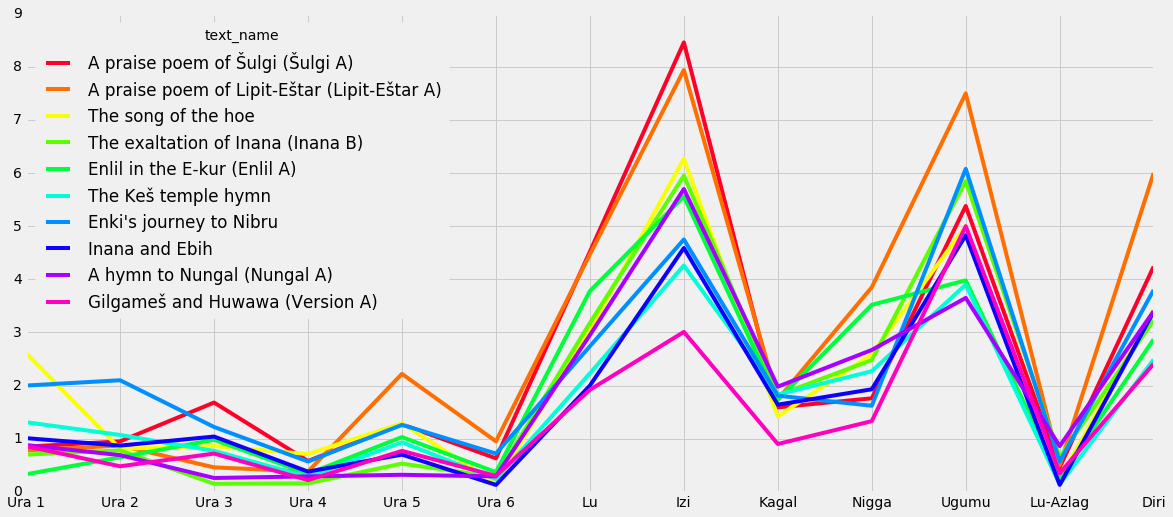

In [39]:
plot_selection(decad)

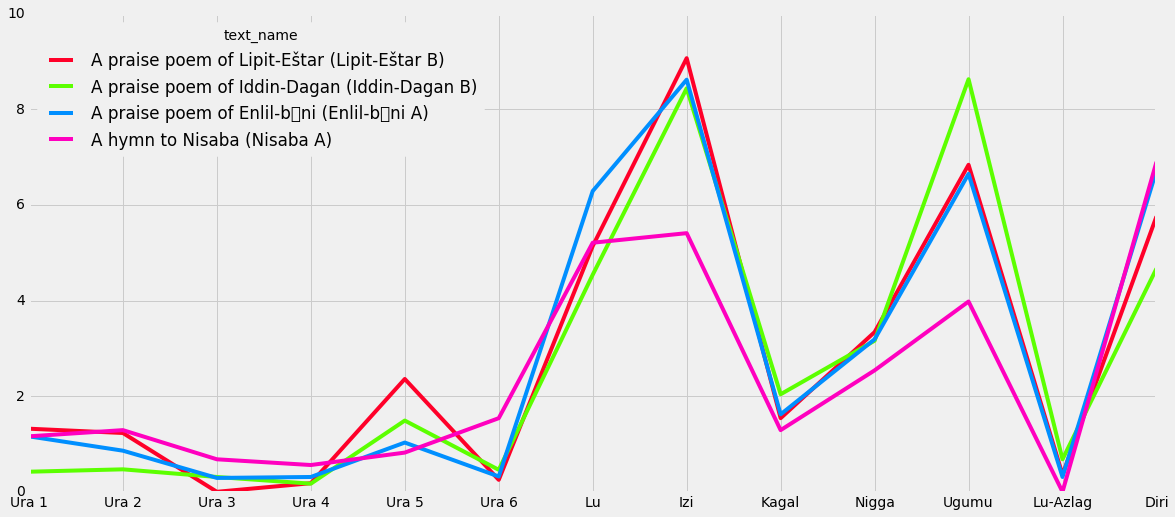

In [40]:
tetrad = ['c.2.5.5.2', 'c.2.5.3.2', 'c.2.5.8.1', 'c.4.16.1']
plot_selection(tetrad)